In [1]:
from functools import partial
import os
import argparse
import yaml
import torch
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler
from util.logger import get_logger
import cv2
import numpy as np
from skimage.io import imsave
import warnings
import shutil
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def image_read(path, mode='RGB'):
    img_BGR = cv2.imread(path).astype('float32')
    assert mode == 'RGB' or mode == 'GRAY' or mode == 'YCrCb', 'mode error'
    if mode == 'RGB':
        img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB) # OpenCV 中用于将图像的颜色空间从 BGR（蓝-绿-红）转换为 RGB（红-绿-蓝）的函数
    elif mode == 'GRAY':  
        img = np.round(cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY))
    elif mode == 'YCrCb':
        img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)
    return img

def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config


In [2]:
# Directly set arguments here for Jupyter Notebook
class Args:
    model_config = 'configs/model_config_imagenet.yaml'
    diffusion_config = 'configs/diffusion_config.yaml'
    gpu = 0
    save_dir = './output'

args = Args()

# logger
logger = get_logger()

# Device setting
# device_str = f"cuda:{args.gpu}" if torch.cuda.is_available() else 'cpu'
# logger.info(f"Device set to {device_str}.")
# device = torch.device(device_str)  
device = "cuda:0"

# Working directory
test_folder=r"input"     
out_path = args.save_dir
os.makedirs(out_path, exist_ok=True)
for img_dir in ['recon', 'progress']:
    os.makedirs(os.path.join(out_path, img_dir), exist_ok=True)
# Working directory
test_folder=r"input"     
out_path = args.save_dir
os.makedirs(out_path, exist_ok=True)
for img_dir in ['recon', 'progress']:
    os.makedirs(os.path.join(out_path, img_dir), exist_ok=True)

In [3]:

# Load model
# Load configurations
model_config = load_yaml(args.model_config)  
diffusion_config = load_yaml(args.diffusion_config)

# Load diffusion sampler
sampler = create_sampler(**diffusion_config) 
model = create_model(**model_config)

model = model.to(device)
model.eval()
sample_fn = partial(sampler.p_sample_loop, model=model)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


inf_img shape : torch.Size([1, 3, 288, 480])
vis_img shape : torch.Size([1, 3, 288, 480])
x_start shape : torch.Size([1, 3, 288, 480])


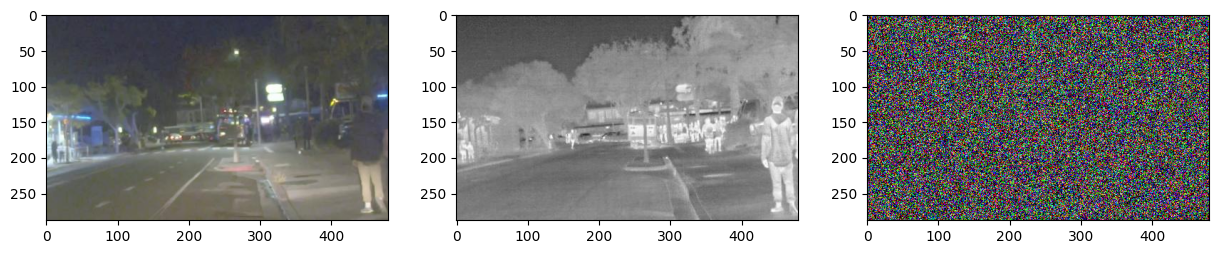

In [4]:

img_name = "FLIR_08248.jpg"

vi_folder = "/home/2021/hexin/XJ2/RoadScene/crop_LR_visible"
ir_folder = "/home/2021/hexin/XJ2/RoadScene/cropinfrared"

vi_dst_path = "/home/2021/hexin/XJ2/DDFM/input2/vi"
ir_dst_path = "/home/2021/hexin/XJ2/DDFM/input2/ir"


list= os.listdir(os.path.join(test_folder,"ir"))

shutil.copy(os.path.join(vi_folder, img_name), vi_dst_path)
shutil.copy(os.path.join(ir_folder, img_name), ir_dst_path)

mode = 'RGB'

#RGB:[1,1,H,W,3] GRAY:[1,1,H,W]
inf_img = image_read(os.path.join(vi_folder,img_name),mode=mode)[np.newaxis,np.newaxis, ...]/255.0 
vis_img = image_read(os.path.join(ir_folder,img_name), mode=mode)[np.newaxis,np.newaxis, ...]/255.0 

#inf_img = inf_img*2-1
#vis_img = vis_img*2-1

if mode == "RGB":
    inf_img = np.squeeze(inf_img, axis=1)  # 变为 (1, 311, 481, 3)
    vis_img = np.squeeze(vis_img, axis=1)  # 变为 (1, 311, 481, 3)
    # 转置维度
    inf_img = np.transpose(inf_img, (0, 3, 1, 2))  # 变为 (1, 3, 311, 481)
    vis_img = np.transpose(vis_img, (0, 3, 1, 2))  # 变为 (1, 3, 311, 481)
elif mode == "GRAY":# (1, 1, H, W)
    h, w = inf_img.shape[2:]

# crop to make divisible
scale = 32
h, w = inf_img.shape[2:]
h = h - h % scale
w = w - w % scale

inf_img = ((torch.FloatTensor(inf_img))[:,:,:h,:w]).to(device)
vis_img = ((torch.FloatTensor(vis_img))[:,:,:h,:w]).to(device)
assert inf_img.shape == vis_img.shape

if mode == "RGB":
    x_start = torch.randn(inf_img.shape, device=device)  
elif mode == "GRAY":# (1, 1, H, W)
    x_start = torch.randn((inf_img.repeat(1, 3, 1, 1)).shape, device=device)  



# Sampling
seed = 3407
torch.manual_seed(seed)
# [1, 3, 256, 256] 的噪声，作为起点
print(f"inf_img shape : {inf_img.shape}")
print(f"vis_img shape : {vis_img.shape}")
print(f"x_start shape : {x_start.shape}")

def tensor_to_numpy(tensor):
    # Ensure tensor is on CPU before converting to numpy array
    return tensor.detach().cpu().numpy()

# Convert tensors to numpy arrays
inf_np = tensor_to_numpy(inf_img.squeeze().permute(1, 2, 0))
vis_np = tensor_to_numpy(vis_img.squeeze().permute(1, 2, 0))
x_np = tensor_to_numpy(x_start.squeeze().permute(1, 2, 0))

# 创建子图
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# 显示原始RGB图像
axs[0].imshow(inf_np)
axs[1].imshow(vis_np)
axs[2].imshow(x_np)
# 显示图像
plt.show()

In [5]:
def norm(sample):
    sample=(sample-np.min(sample))/(np.max(sample)-np.min(sample))
    sample=((sample)*255).astype(np.uint8)
    return sample

In [6]:
with torch.no_grad(): # rho=0.001
    sample = sample_fn(x_start=x_start, record=True, I = inf_img, V = vis_img, save_root=out_path, img_index = os.path.splitext(img_name)[0], lamb=0.5,rho=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]

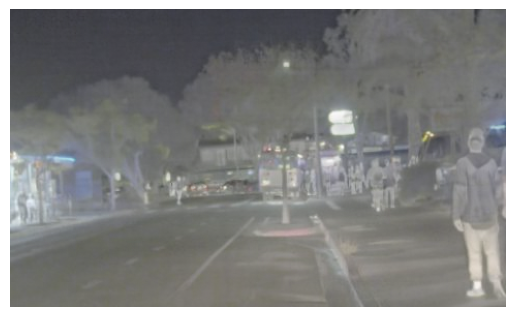

In [7]:
rgb_image = sample.squeeze().permute(1, 2, 0).cpu().numpy()

# 显示图像
plt.imshow(rgb_image)
plt.axis('off')  # 关闭坐标轴
plt.show()

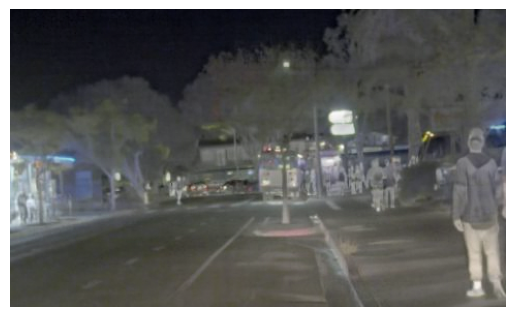

2024-07-29 20:42:20,358 [DPS] >> Save result in ./output/recon  FLIR_08248.jpg


./output/recon


In [8]:

sample_norm=norm(rgb_image)
# 显示图像
plt.imshow(sample_norm)
plt.axis('off')  # 关闭坐标轴
plt.show()
save_path = os.path.join(out_path, 'recon')
print(save_path)
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_name = "{}.png".format(img_name.split(".")[0])
imsave(os.path.join(save_path, save_name),sample_norm)
logger.info(f"Save result in {save_path}  {img_name}")


In [9]:
print(sample_norm.shape)

(288, 480, 3)
